# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4202496/11490434 [=========>....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 11:00 - loss: 0.6930

  32/1875 [..............................] - ETA: 2s - loss: 0.5302   

  66/1875 [>.............................] - ETA: 2s - loss: 0.4477

 101/1875 [>.............................] - ETA: 2s - loss: 0.4056

 137/1875 [=>............................] - ETA: 2s - loss: 0.3786

 173/1875 [=>............................] - ETA: 2s - loss: 0.3592

 208/1875 [==>...........................] - ETA: 2s - loss: 0.3446

 245/1875 [==>...........................] - ETA: 2s - loss: 0.3320

 279/1875 [===>..........................] - ETA: 2s - loss: 0.3222

 315/1875 [====>.........................] - ETA: 2s - loss: 0.3132

 351/1875 [====>.........................] - ETA: 2s - loss: 0.3053

 387/1875 [=====>........................] - ETA: 2s - loss: 0.2984

 421/1875 [=====>........................] - ETA: 2s - loss: 0.2925

 457/1875 [======>.......................] - ETA: 2s - loss: 0.2868

 490/1875 [======>.......................] - ETA: 2s - loss: 0.2820

 525/1875 [=======>......................] - ETA: 1s - loss: 0.2773

 561/1875 [=======>......................] - ETA: 1s - loss: 0.2729

 597/1875 [========>.....................] - ETA: 1s - loss: 0.2687

 633/1875 [=========>....................] - ETA: 1s - loss: 0.2649

 669/1875 [=========>....................] - ETA: 1s - loss: 0.2613

 704/1875 [==========>...................] - ETA: 1s - loss: 0.2580

 740/1875 [==========>...................] - ETA: 1s - loss: 0.2548

 781/1875 [===========>..................] - ETA: 1s - loss: 0.2514

 816/1875 [============>.................] - ETA: 1s - loss: 0.2486

 853/1875 [============>.................] - ETA: 1s - loss: 0.2459

 890/1875 [=============>................] - ETA: 1s - loss: 0.2433

 927/1875 [=============>................] - ETA: 1s - loss: 0.2408

 964/1875 [==============>...............] - ETA: 1s - loss: 0.2384

1001/1875 [===============>..............] - ETA: 1s - loss: 0.2361

1040/1875 [===============>..............] - ETA: 1s - loss: 0.2339

1079/1875 [================>.............] - ETA: 1s - loss: 0.2317

1116/1875 [================>.............] - ETA: 1s - loss: 0.2297

1152/1875 [=================>............] - ETA: 1s - loss: 0.2278

1187/1875 [=================>............] - ETA: 0s - loss: 0.2261

1224/1875 [==================>...........] - ETA: 0s - loss: 0.2243

1261/1875 [===================>..........] - ETA: 0s - loss: 0.2226

1299/1875 [===================>..........] - ETA: 0s - loss: 0.2209

1334/1875 [====================>.........] - ETA: 0s - loss: 0.2194

1367/1875 [====================>.........] - ETA: 0s - loss: 0.2181

1400/1875 [=====================>........] - ETA: 0s - loss: 0.2167

1433/1875 [=====================>........] - ETA: 0s - loss: 0.2154

1468/1875 [======================>.......] - ETA: 0s - loss: 0.2141

1503/1875 [=======================>......] - ETA: 0s - loss: 0.2128

1539/1875 [=======================>......] - ETA: 0s - loss: 0.2115

1575/1875 [========================>.....] - ETA: 0s - loss: 0.2103

1611/1875 [========================>.....] - ETA: 0s - loss: 0.2090

1647/1875 [=========================>....] - ETA: 0s - loss: 0.2078

1683/1875 [=========================>....] - ETA: 0s - loss: 0.2067

1718/1875 [==========================>...] - ETA: 0s - loss: 0.2056

1754/1875 [===========================>..] - ETA: 0s - loss: 0.2045

1788/1875 [===========================>..] - ETA: 0s - loss: 0.2035

1821/1875 [============================>.] - ETA: 0s - loss: 0.2025

1859/1875 [============================>.] - ETA: 0s - loss: 0.2014

1875/1875 [==============================] - 3s 1ms/step - loss: 0.2010


Epoch 2/5
   1/1875 [..............................] - ETA: 10s - loss: 0.1054

  38/1875 [..............................] - ETA: 2s - loss: 0.1109 

  74/1875 [>.............................] - ETA: 2s - loss: 0.1106

 111/1875 [>.............................] - ETA: 2s - loss: 0.1104

 146/1875 [=>............................] - ETA: 2s - loss: 0.1102

 183/1875 [=>............................] - ETA: 2s - loss: 0.1100

 220/1875 [==>...........................] - ETA: 2s - loss: 0.1099

 257/1875 [===>..........................] - ETA: 2s - loss: 0.1098

 294/1875 [===>..........................] - ETA: 2s - loss: 0.1097

 332/1875 [====>.........................] - ETA: 2s - loss: 0.1095

 369/1875 [====>.........................] - ETA: 2s - loss: 0.1094

 407/1875 [=====>........................] - ETA: 2s - loss: 0.1093

 444/1875 [======>.......................] - ETA: 1s - loss: 0.1092

 481/1875 [======>.......................] - ETA: 1s - loss: 0.1091

 519/1875 [=======>......................] - ETA: 1s - loss: 0.1090

 557/1875 [=======>......................] - ETA: 1s - loss: 0.1089

 595/1875 [========>.....................] - ETA: 1s - loss: 0.1088

 632/1875 [=========>....................] - ETA: 1s - loss: 0.1087

 669/1875 [=========>....................] - ETA: 1s - loss: 0.1086

 705/1875 [==========>...................] - ETA: 1s - loss: 0.1085

 741/1875 [==========>...................] - ETA: 1s - loss: 0.1084

 778/1875 [===========>..................] - ETA: 1s - loss: 0.1083

 815/1875 [============>.................] - ETA: 1s - loss: 0.1082

 853/1875 [============>.................] - ETA: 1s - loss: 0.1082

 887/1875 [=============>................] - ETA: 1s - loss: 0.1081

 922/1875 [=============>................] - ETA: 1s - loss: 0.1080

 960/1875 [==============>...............] - ETA: 1s - loss: 0.1079

1002/1875 [===============>..............] - ETA: 1s - loss: 0.1078

1044/1875 [===============>..............] - ETA: 1s - loss: 0.1077

1079/1875 [================>.............] - ETA: 1s - loss: 0.1076

1115/1875 [================>.............] - ETA: 1s - loss: 0.1075

1150/1875 [=================>............] - ETA: 0s - loss: 0.1074

1185/1875 [=================>............] - ETA: 0s - loss: 0.1073

1221/1875 [==================>...........] - ETA: 0s - loss: 0.1073

1257/1875 [===================>..........] - ETA: 0s - loss: 0.1072

1296/1875 [===================>..........] - ETA: 0s - loss: 0.1071

1340/1875 [====================>.........] - ETA: 0s - loss: 0.1070

1378/1875 [=====================>........] - ETA: 0s - loss: 0.1069

1408/1875 [=====================>........] - ETA: 0s - loss: 0.1069

1445/1875 [======================>.......] - ETA: 0s - loss: 0.1068

1482/1875 [======================>.......] - ETA: 0s - loss: 0.1067

1515/1875 [=======================>......] - ETA: 0s - loss: 0.1066

1550/1875 [=======================>......] - ETA: 0s - loss: 0.1066

1583/1875 [========================>.....] - ETA: 0s - loss: 0.1065

1615/1875 [========================>.....] - ETA: 0s - loss: 0.1064

1651/1875 [=========================>....] - ETA: 0s - loss: 0.1064

1684/1875 [=========================>....] - ETA: 0s - loss: 0.1063

1719/1875 [==========================>...] - ETA: 0s - loss: 0.1062

1754/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1788/1875 [===========================>..] - ETA: 0s - loss: 0.1061

1822/1875 [============================>.] - ETA: 0s - loss: 0.1060

1857/1875 [============================>.] - ETA: 0s - loss: 0.1060

1875/1875 [==============================] - 3s 1ms/step - loss: 0.1059


Epoch 3/5
   1/1875 [..............................] - ETA: 2s - loss: 0.1093

  39/1875 [..............................] - ETA: 2s - loss: 0.0986

  72/1875 [>.............................] - ETA: 2s - loss: 0.0982

 105/1875 [>.............................] - ETA: 2s - loss: 0.0980

 140/1875 [=>............................] - ETA: 2s - loss: 0.0980

 174/1875 [=>............................] - ETA: 2s - loss: 0.0980

 208/1875 [==>...........................] - ETA: 2s - loss: 0.0979

 238/1875 [==>...........................] - ETA: 2s - loss: 0.0979

 275/1875 [===>..........................] - ETA: 2s - loss: 0.0979

 318/1875 [====>.........................] - ETA: 2s - loss: 0.0978

 352/1875 [====>.........................] - ETA: 2s - loss: 0.0978

 391/1875 [=====>........................] - ETA: 2s - loss: 0.0977

 432/1875 [=====>........................] - ETA: 2s - loss: 0.0977

 471/1875 [======>.......................] - ETA: 1s - loss: 0.0977

 511/1875 [=======>......................] - ETA: 1s - loss: 0.0977

 555/1875 [=======>......................] - ETA: 1s - loss: 0.0977

 592/1875 [========>.....................] - ETA: 1s - loss: 0.0977

 628/1875 [=========>....................] - ETA: 1s - loss: 0.0976

 664/1875 [=========>....................] - ETA: 1s - loss: 0.0976

 701/1875 [==========>...................] - ETA: 1s - loss: 0.0976

 738/1875 [==========>...................] - ETA: 1s - loss: 0.0976

 775/1875 [===========>..................] - ETA: 1s - loss: 0.0976

 811/1875 [===========>..................] - ETA: 1s - loss: 0.0976

 848/1875 [============>.................] - ETA: 1s - loss: 0.0976

 884/1875 [=============>................] - ETA: 1s - loss: 0.0976

 927/1875 [=============>................] - ETA: 1s - loss: 0.0976

 966/1875 [==============>...............] - ETA: 1s - loss: 0.0975

1002/1875 [===============>..............] - ETA: 1s - loss: 0.0975

1029/1875 [===============>..............] - ETA: 1s - loss: 0.0975

1060/1875 [===============>..............] - ETA: 1s - loss: 0.0975

1085/1875 [================>.............] - ETA: 1s - loss: 0.0975

1107/1875 [================>.............] - ETA: 1s - loss: 0.0975

1128/1875 [=================>............] - ETA: 1s - loss: 0.0975

1155/1875 [=================>............] - ETA: 1s - loss: 0.0975

1181/1875 [=================>............] - ETA: 1s - loss: 0.0975

1207/1875 [==================>...........] - ETA: 0s - loss: 0.0975

1233/1875 [==================>...........] - ETA: 0s - loss: 0.0975

1259/1875 [===================>..........] - ETA: 0s - loss: 0.0975

1284/1875 [===================>..........] - ETA: 0s - loss: 0.0975

1315/1875 [====================>.........] - ETA: 0s - loss: 0.0975

1345/1875 [====================>.........] - ETA: 0s - loss: 0.0974

1372/1875 [====================>.........] - ETA: 0s - loss: 0.0974

1405/1875 [=====================>........] - ETA: 0s - loss: 0.0974

1433/1875 [=====================>........] - ETA: 0s - loss: 0.0974

1467/1875 [======================>.......] - ETA: 0s - loss: 0.0974

1501/1875 [=======================>......] - ETA: 0s - loss: 0.0974

1535/1875 [=======================>......] - ETA: 0s - loss: 0.0974

1565/1875 [========================>.....] - ETA: 0s - loss: 0.0974

1598/1875 [========================>.....] - ETA: 0s - loss: 0.0974

1631/1875 [=========================>....] - ETA: 0s - loss: 0.0974

1661/1875 [=========================>....] - ETA: 0s - loss: 0.0974

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0974

1727/1875 [==========================>...] - ETA: 0s - loss: 0.0974

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0974

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0973

1826/1875 [============================>.] - ETA: 0s - loss: 0.0973

1856/1875 [============================>.] - ETA: 0s - loss: 0.0973

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0973


Epoch 4/5


   1/1875 [..............................] - ETA: 3s - loss: 0.0981

  33/1875 [..............................] - ETA: 2s - loss: 0.0958

  64/1875 [>.............................] - ETA: 2s - loss: 0.0959

  95/1875 [>.............................] - ETA: 2s - loss: 0.0959

 129/1875 [=>............................] - ETA: 2s - loss: 0.0958

 165/1875 [=>............................] - ETA: 2s - loss: 0.0958

 198/1875 [==>...........................] - ETA: 2s - loss: 0.0957

 232/1875 [==>...........................] - ETA: 2s - loss: 0.0958

 256/1875 [===>..........................] - ETA: 2s - loss: 0.0958

 285/1875 [===>..........................] - ETA: 2s - loss: 0.0958

 316/1875 [====>.........................] - ETA: 2s - loss: 0.0958

 347/1875 [====>.........................] - ETA: 2s - loss: 0.0958

 384/1875 [=====>........................] - ETA: 2s - loss: 0.0958

 420/1875 [=====>........................] - ETA: 2s - loss: 0.0958

 451/1875 [======>.......................] - ETA: 2s - loss: 0.0958

 482/1875 [======>.......................] - ETA: 2s - loss: 0.0958

 515/1875 [=======>......................] - ETA: 2s - loss: 0.0958

 546/1875 [=======>......................] - ETA: 2s - loss: 0.0958

 578/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 607/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 639/1875 [=========>....................] - ETA: 1s - loss: 0.0958

 669/1875 [=========>....................] - ETA: 1s - loss: 0.0958

 699/1875 [==========>...................] - ETA: 1s - loss: 0.0958

 728/1875 [==========>...................] - ETA: 1s - loss: 0.0959

 758/1875 [===========>..................] - ETA: 1s - loss: 0.0959

 790/1875 [===========>..................] - ETA: 1s - loss: 0.0959

 822/1875 [============>.................] - ETA: 1s - loss: 0.0959

 855/1875 [============>.................] - ETA: 1s - loss: 0.0959

 884/1875 [=============>................] - ETA: 1s - loss: 0.0959

 913/1875 [=============>................] - ETA: 1s - loss: 0.0959

 942/1875 [==============>...............] - ETA: 1s - loss: 0.0959

 973/1875 [==============>...............] - ETA: 1s - loss: 0.0959

1006/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1036/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1070/1875 [================>.............] - ETA: 1s - loss: 0.0958

1100/1875 [================>.............] - ETA: 1s - loss: 0.0958

1133/1875 [=================>............] - ETA: 1s - loss: 0.0958

1160/1875 [=================>............] - ETA: 1s - loss: 0.0958

1189/1875 [==================>...........] - ETA: 1s - loss: 0.0958

1221/1875 [==================>...........] - ETA: 1s - loss: 0.0958

1251/1875 [===================>..........] - ETA: 1s - loss: 0.0958

1276/1875 [===================>..........] - ETA: 0s - loss: 0.0958

1304/1875 [===================>..........] - ETA: 0s - loss: 0.0958

1335/1875 [====================>.........] - ETA: 0s - loss: 0.0958

1366/1875 [====================>.........] - ETA: 0s - loss: 0.0958

1395/1875 [=====================>........] - ETA: 0s - loss: 0.0958

1424/1875 [=====================>........] - ETA: 0s - loss: 0.0958

1452/1875 [======================>.......] - ETA: 0s - loss: 0.0958

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0958

1506/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1535/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1559/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1591/1875 [========================>.....] - ETA: 0s - loss: 0.0958

1621/1875 [========================>.....] - ETA: 0s - loss: 0.0958

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1677/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1704/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1732/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1761/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1788/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1817/1875 [============================>.] - ETA: 0s - loss: 0.0958

1845/1875 [============================>.] - ETA: 0s - loss: 0.0958

1875/1875 [==============================] - ETA: 0s - loss: 0.0958

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0958


Epoch 5/5
   1/1875 [..............................] - ETA: 5s - loss: 0.1035

  31/1875 [..............................] - ETA: 3s - loss: 0.0966

  54/1875 [..............................] - ETA: 3s - loss: 0.0964

  80/1875 [>.............................] - ETA: 3s - loss: 0.0961

 106/1875 [>.............................] - ETA: 3s - loss: 0.0958

 137/1875 [=>............................] - ETA: 3s - loss: 0.0956

 159/1875 [=>............................] - ETA: 3s - loss: 0.0955

 182/1875 [=>............................] - ETA: 3s - loss: 0.0955

 211/1875 [==>...........................] - ETA: 3s - loss: 0.0954

 239/1875 [==>...........................] - ETA: 3s - loss: 0.0954

 270/1875 [===>..........................] - ETA: 3s - loss: 0.0953

 297/1875 [===>..........................] - ETA: 3s - loss: 0.0953

 332/1875 [====>.........................] - ETA: 2s - loss: 0.0952

 359/1875 [====>.........................] - ETA: 2s - loss: 0.0952

 389/1875 [=====>........................] - ETA: 2s - loss: 0.0952

 418/1875 [=====>........................] - ETA: 2s - loss: 0.0952

 445/1875 [======>.......................] - ETA: 2s - loss: 0.0952

 474/1875 [======>.......................] - ETA: 2s - loss: 0.0952

 507/1875 [=======>......................] - ETA: 2s - loss: 0.0952

 533/1875 [=======>......................] - ETA: 2s - loss: 0.0951

 564/1875 [========>.....................] - ETA: 2s - loss: 0.0951

 594/1875 [========>.....................] - ETA: 2s - loss: 0.0951

 621/1875 [========>.....................] - ETA: 2s - loss: 0.0951

 648/1875 [=========>....................] - ETA: 2s - loss: 0.0951

 677/1875 [=========>....................] - ETA: 2s - loss: 0.0951

 705/1875 [==========>...................] - ETA: 2s - loss: 0.0951

 740/1875 [==========>...................] - ETA: 2s - loss: 0.0951

 773/1875 [===========>..................] - ETA: 1s - loss: 0.0951

 808/1875 [===========>..................] - ETA: 1s - loss: 0.0951

 842/1875 [============>.................] - ETA: 1s - loss: 0.0951

 868/1875 [============>.................] - ETA: 1s - loss: 0.0951

 899/1875 [=============>................] - ETA: 1s - loss: 0.0951

 933/1875 [=============>................] - ETA: 1s - loss: 0.0951

 968/1875 [==============>...............] - ETA: 1s - loss: 0.0951

1003/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1039/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1075/1875 [================>.............] - ETA: 1s - loss: 0.0951

1109/1875 [================>.............] - ETA: 1s - loss: 0.0951

1144/1875 [=================>............] - ETA: 1s - loss: 0.0951

1181/1875 [=================>............] - ETA: 1s - loss: 0.0951

1208/1875 [==================>...........] - ETA: 1s - loss: 0.0951

1244/1875 [==================>...........] - ETA: 1s - loss: 0.0951

1280/1875 [===================>..........] - ETA: 0s - loss: 0.0951

1314/1875 [====================>.........] - ETA: 0s - loss: 0.0951

1347/1875 [====================>.........] - ETA: 0s - loss: 0.0951

1382/1875 [=====================>........] - ETA: 0s - loss: 0.0951

1417/1875 [=====================>........] - ETA: 0s - loss: 0.0951

1453/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1488/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1521/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1554/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1590/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1690/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1759/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1826/1875 [============================>.] - ETA: 0s - loss: 0.0951

1854/1875 [============================>.] - ETA: 0s - loss: 0.0951

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0951


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

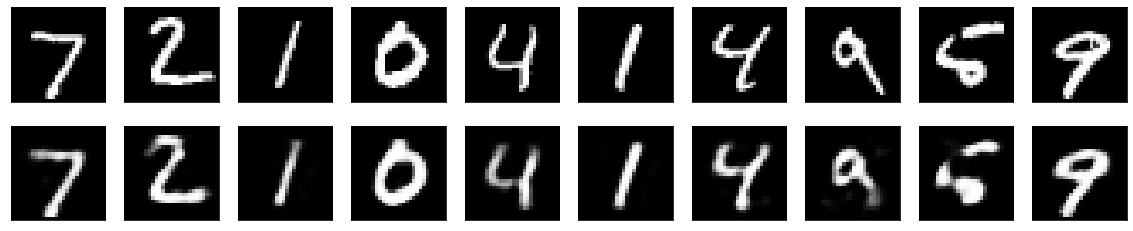

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
